# SYMBOLIC STUDY
## **STEERING RACK**
------------------------------------

### **IMPORTANT NOTES**
#### **COLAB Machine Setup**
If starting a new Colab session, Please open the [colab_setup.ipynb](https://colab.research.google.com/github/khaledghobashy/smbd/blob/master/examples/colab_setup.ipynb) and follow the instructions there.
A new Colab session does not mean a new notebook session, you can have various notebook sessions on the same Colab session. The Colab session linked to your Google account expires in 12 hours, and so any data saved on that remote machine will be lost.</br>
When you run the first cell, Colab will prompt a warning that *"This notebook was not authored by Google."* and that it is loaded from GitHub. Un-check the **Reset all runtimes before running** then press **RUN ANYWAY**.

#### **Package Path.**
*This step is temporary unitll the package can be installed via conda and/or pip*
- **Colab**. </br>
For a Cloab session, the ```pkg_path``` variable is the one relevant to the repository path on the Colab remote machine. This should be used if you are running the notebook on Colab.
- **Local Machine**. </br>
The ```pkg_path``` variable is where I have the repository on my machine. You should change it to where you cloned the repository on your machine.

#### **Projects Directory**
- **Colab**.</br>
The ```projects_dir``` variable should not be changed.
- **Local Machine**. </br>
The ```projects_dir``` should be changed to match your desired directory where you store your projects.

--------------------------------------------------------------

## **SYSTEM DESCRIPTION**
-------------------------

### **Important Note**
The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.

### **Summary**

### **Topology Layout**

---------------------------------------------------------------
---------------------------------------------------------------

In [1]:
import sys

### Colab Session
*Run if in a Colab Session Only!*

In [2]:
projects_dir = '/content/projects'
pkg_path = '/content/smbd'
sys.path.append(pkg_path)

### Local Session
*Run if on your Local Machine!*</br>
*Do not forget to change the variables below as illustrated in the notes!*

In [2]:
projects_dir = r'C:\Users\khaled.ghobashy\Desktop\smbd\examples\notebooks\fsae_car'
pkg_path = r'C:\Users\khaled.ghobashy\Desktop\smbd'
sys.path.append(pkg_path)

---------------------------------------------------------------
---------------------------------------------------------------

## **SYMBOLIC TOPOLOGY**
------------------------

In this section, we create the symbolic topology that captures the topological layout that we just discussed.</br>
Defining the topology is very simple. We start by importing the ```template_topology``` class and create a new instance that represents our symbolic model. Then we start adding the components we discussed earlier, starting by the bodies, then the joints, actuators and forces, and thats it.</br>
These components will be represented symbolically, and therefore there is no need for any numerical inputs at this step.

The system is stored in a form of a network graph that stores all the data needed for the assemblage of the system equations later. But even before the assemblage process, we can gain helpful insights about our system as well be shown.


In [3]:
import os
from smbd.systems import template_topology, configuration

In [4]:
database_directory = os.path.abspath('../../')
model_name = 'steering_rack'

In [5]:
sym_model = template_topology(model_name)

### Adding Bodies

In [6]:
sym_model.add_body('rack')
sym_model.add_body('chassis', virtual=True)

### Adding Joints

In [8]:
sym_model.add_joint.translational('rack', 'rbs_rack', 'vbs_chassis')

### Adding Actuators

In [9]:
# Adding Actuators
# ================
sym_model.add_actuator.translational_actuator('rack_act', 'jcs_rack')

### Adding Forces

In [7]:
# Adding Forces
# =============

### **SYMBOLIC CHARACTERISTICS**

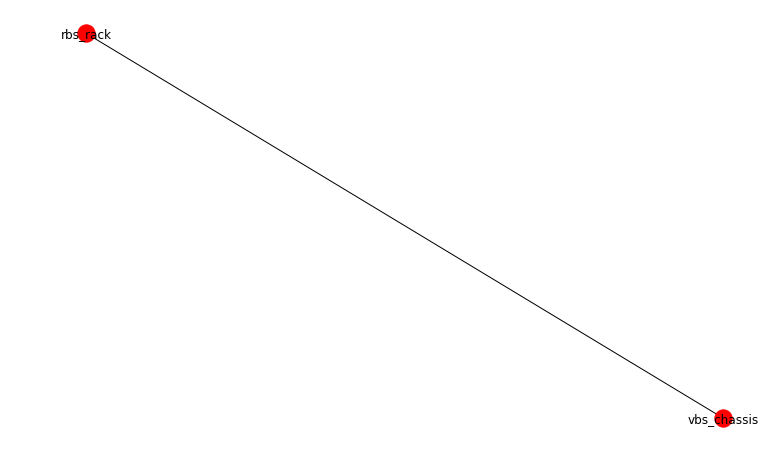

In [10]:
sym_model.topology.draw_constraints_topology()

### **ASSEMBLING**

This is the last step of the symbolic building process, where we make the system starts the assemblage process of the governing equations, which will be used then in the code generation for the numerical simulation, and also can be used for further symbolic manipulations.</br>

*Note: The equations' notations will be discussed in the tool documentation files.*

In [11]:
sym_model.save('objects')
sym_model.assemble()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM CONFIGURATION**
---------------------------

In this step we define a symbolic configuration of our symbolic topology. As you may have noticed in the symbolic topology building step, we only cared about the *'topology'*, thats is the system bodies and their connectivity, and we did not care explicitly with how these components are configured in space.</br>
In order to create a valid numerical simulation session, we have to provide the system with its numerical configuration needed, for example, the joints' locations and orientations. The symbolic topology in its raw form will require you to manually enter all these numerical arguments, which can be cumbersome even for smaller systems. This can be checked by checking the configuration inputs of the symbolic configuration as ```config._config.input_nodes```

Here we start by stating the symbolic inputs we wish to use instead of the default inputs set, and then we define the relation between these newly defined arguments and the original ones. The details of this process will be provided in the documentation.

In [12]:
config_name = '%s_cfg'%model_name
sym_config = configuration(config_name, sym_model)

### CONFIGURATION INPUTS

In [13]:
sym_config.add_point.UserInput('rack_end', mirror=True)
sym_config.add_vector.UserInput('y')

### CONFIGURATION RELATIONS

In [14]:
# Translational Joint:
# ====================
sym_config.add_relation.Centered('pt1_jcs_rack', ('hpr_rack_end', 'hpl_rack_end'))
sym_config.add_relation.Equal_to('ax1_jcs_rack', ('vcs_y',))


### GEOMETRIES

Here we start defining basic geometric shapes that can represents the shapes of the bodies in our system. This serves two points:
- Visualization and Animation in blender.
- Evaluating the bodies inertia properties from these basic geometries instead of explicit definition.

In [15]:
sym_config.add_scalar.UserInput('rack_radius')

sym_config.add_geometry.Cylinder_Geometry('rack', ('hpr_rack_end','hpl_rack_end','s_rack_radius'))
sym_config.assign_geometry_to_body('rbs_rack', 'gms_rack')

### ASSEMBLING

In [16]:
sym_config.assemble()
sym_config.extract_inputs_to_csv('config_inputs')

---------------------------------------------------------------
---------------------------------------------------------------

## **CODE GENERATION**
----------------------

This step aims to create a valid code that can be used for numerical simulation. We will use the ***python code generators*** to create a valid numerical simulation environment in python.</br>
Theoretically, the symbolic environment is uncoupled from the simulation environment, which opens the door to create various simulation environments that can be in any language.

In [17]:
from smbd.numenv.python.codegen.projects import templatebased_project

In [18]:
python_project = templatebased_project(database_directory, sym_model, sym_config)
python_project.create()

File full path : C:\Users\khaled.ghobashy\Desktop\smbd\examples\notebooks\fsae_car\numenv\python\templates\steering_rack\steering_rack.py
File full path : C:\Users\khaled.ghobashy\Desktop\smbd\examples\notebooks\fsae_car\numenv\python\templates\steering_rack\steering_rack_cfg.py


### Generating Blender Script

In [19]:
from smbd.utilities.blender.codegen import script_generator

In [20]:
bpy_code = script_generator(sym_config.config)
bpy_code.write_code_file(os.path.join(database_directory, 'numenv/visenv/'))